Creación del entorno Ms-Pac-Man

In [1]:
import gym
import numpy as np

%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import os
import tensorflow as tf

In [3]:
env = gym.make("MsPacman-v0")

In [4]:
obs = env.reset()

In [5]:
obs.shape # [altura, anchura, canales]

(210, 160, 3)

In [6]:
env.action_space

Discrete(9)

Como se puede ver, hay nueve acciones discretas disponibles, que corresponden a las nueve posiciones posibles del joystick (izquierda, derecha, arriba, abajo, centro, superior izquierda, etc.), y las observaciones son simplemente capturas de pantalla de la pantalla Atari

Estas imágenes son un poco grandes, por lo que crearemos una pequeña función de preprocesamiento que recortará la imagen y la reducirá a 88 × 80 píxeles, la convertirá a escala de grises y mejorará el contraste de la Sra. Pac-Man. Esto reducirá la cantidad de cálculos requeridos por el DQN y acelerará el entrenamiento.

In [7]:
mspacman_color = np.array([210, 164, 74]).mean()

In [8]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [9]:
def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # recortar y reducir tamaño
    img = img.mean(axis=2) # a escala de grises
    img[img==mspacman_color] = 0 # improve contrast
    img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    return img.reshape(88, 80, 1)

In [10]:
img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


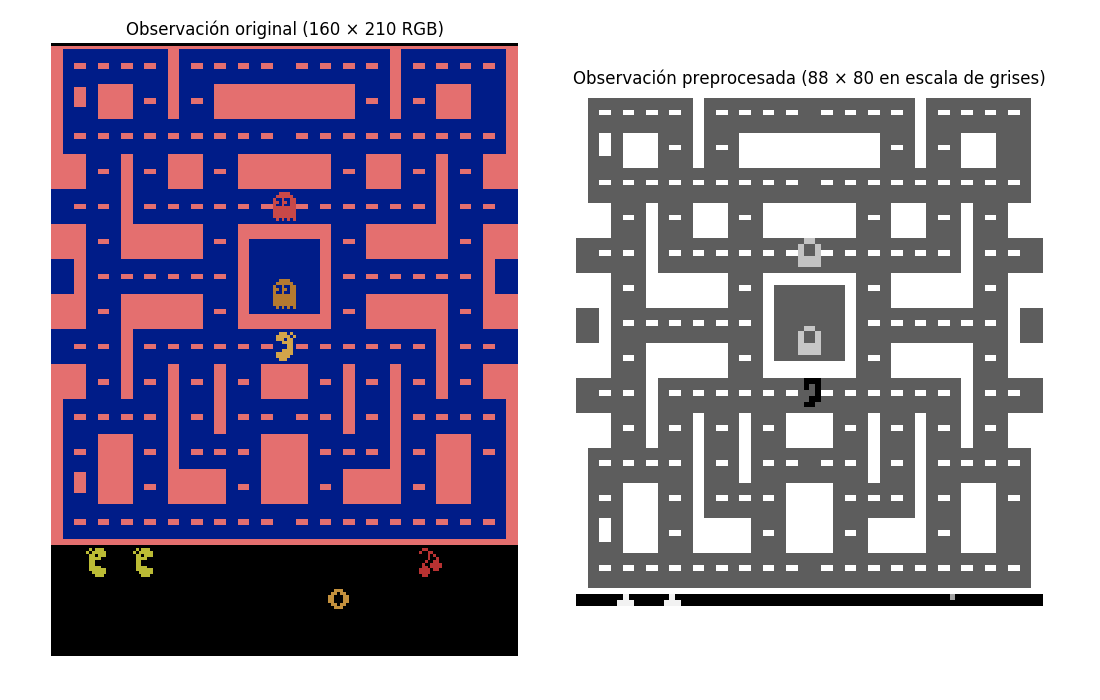

Saving figure preprocessing_plot


In [11]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Observación original (160 × 210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Observación preprocesada (88 × 80 en escala de grises)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

A continuación, vamos a crear el DQN. Simplemente podría tomar un par estado-acción (s, a) como entrada y generar una estimación de
el Q-Value Q (s, a) correspondiente, pero como las acciones son discretas, es más conveniente utilizar una red neuronal que tome solo un estado s como entrada y genere una estimación de Q-Value por acción. El DQN estará compuesto por tres capas convolucionales, seguidas por dos capas totalmente conectadas, incluida la capa de salida

![imagen](images/model.png)

Como veremos, el algoritmo de entrenamiento que usaremos requiere dos DQN con la misma arquitectura (pero con diferentes parámetros): uno se usará para conducir a la Sra. Pac-Man durante el entrenamiento (el actor), y el otro observará al actor y Aprende de sus pruebas y errores (la crítica). A intervalos regulares copiaremos la crítica al actor. Ya que necesitamos dos DQN idénticos, crearemos una función q_network () para construirlos:

In [12]:
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10 # conv3 tiene 64 mapas de 11x10 cada uno
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n # 9 acciones discretas están disponibles
initializer = tf.contrib.layers.variance_scaling_initializer()

In [13]:
def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

La primera parte de este código define los hiperparámetros de la arquitectura DQN. Luego, la función q_network () crea el DQN, tomando el estado X_state del entorno como entrada y el nombre del ámbito de la variable. Tenga en cuenta que solo usaremos una observación para representar el estado del entorno, ya que casi no hay un estado oculto (excepto por los objetos parpadeantes y las direcciones de los fantasmas).

Ahora vamos a crear el marcador de posición de entrada, los dos DQN y la operación para copiar el DQN crítico al DQN actor:

In [14]:
tf.reset_default_graph()

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [15]:
online_vars

{'/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/dense_1/kernel:0' shape=(512, 9) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/onl

Retrocedamos por un segundo: ahora tenemos dos DQN que son capaces de tomar un estado de entorno (es decir, una observación preprocesada) como entrada y salida de un valor Q estimado para cada acción posible en ese estado.

Además, tenemos una operación llamada copy_critic_to_actor para copiar todas las variables entrenables del crítico DQN al actor DQN. Utilizamos la función tf.group () de TensorFlow para agrupar todas las operaciones de asignación en una sola operación conveniente. 

El actor DQN se puede usar para interpretar a la Sra. Pac-Man (inicialmente muy mal). 
Como se mencionó anteriormente, desea que explore el juego lo suficientemente a fondo, por lo que generalmente desea combinarlo con una política avariciosa u otra estrategia de exploración. Pero ¿qué pasa con la crítica DQN? ¿Cómo aprenderá a jugar el juego? 

La respuesta corta es que intentará que sus predicciones de Q-Value coincidan con los Q-Values estimados por el actor a través de su experiencia en el juego. Específicamente, dejaremos que el actor juegue por un tiempo, almacenando todas sus experiencias en una memoria de repetición.

Cada memoria será un 5-tupla (estado, acción, próximo estado, recompensa, continuar), donde el elemento "continuar" será igual a 0.0 cuando el juego termine, o 1.0 de lo contrario. Luego, a intervalos regulares, muestrearemos un lote de memorias de la memoria de repetición, y estimaremos los valores Q de estas memorias. 

Finalmente, capacitaremos al crítico DQN para predecir estos valores Q usando técnicas de aprendizaje supervisado regularmente. Una vez cada pocas iteraciones de entrenamiento, copiaremos la crítica DQN al actor DQN. ¡Y listo!

In [16]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### NOTA

La función ReplayMemory es opcional, pero muy recomendable. Sin ella, entrenaría al crítico DQN usando experiencias consecutivas que pueden estar muy relacionadas.

Esto introduciría una gran cantidad de sesgo y ralentizaría la convergencia del algoritmo de entrenamiento.
Mediante el uso de una memoria de reproducción, nos aseguramos de que las memorias suministradas al algoritmo de entrenamiento puedan usarse bastante sin correlacionar.

In [17]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [18]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [19]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

Necesitaremos al actor para explorar el juego. Usaremos la política ε-greedy, y gradualmente disminuiremos ε de 1.0 a 0.05, en 50,000 pasos de entrenamiento:

In [20]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 200000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

vamos a inicializar algunas variables:

In [21]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

In [22]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [ ]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Puede interrumpir la celda de arriba en cualquier momento para probar a su agente usando la celda de abajo. Luego, puede ejecutar la celda anterior una vez más, cargará los últimos parámetros guardados y reanudará el entrenamiento.

In [23]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


In [24]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


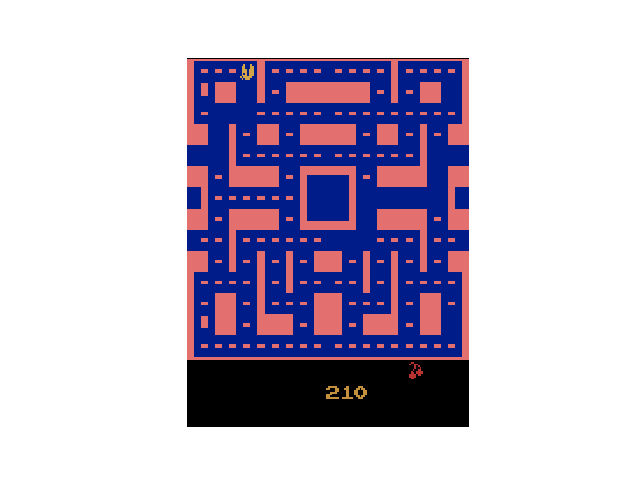

In [25]:
plot_animation(frames)

<video src="images/video.mov" controls>
Your browser does not support the video tag
</video>

# Preguntas

1) How would you define Reinforcement Learning? How is it different from regular supervised or
unsupervised learning?

En cierta forma es parecido a como aprendemos los humanos. Probamos cosas al azar y si nos dan algún tipo de reward tratamos de seguir haciéndolo y si algo sale mal evitamos hacerlo. 

Es diferente al aprendizaje supervisado en el hecho de que no hay etiquetas que te digan la respuesta. Estás en un entorno que te da premios o castigos dependiendo de lo que hagas. El aprendizaje supervisado trata de ajsutar basándose en esas etiquetas mientras que el aprendizaje por refuerzo busca encontrar patrones de comportamientos que aumenten la recompenza.

Es diferente al aprendizaje no supervisado en sus objetivos. Como mencioné anteriormente en el aprendizaje por refuerzo se busca encontrar un comportamiento que maximice ganancias mientras que en el aprendizaje no supervisado busca encontrar diferencias y patrones en los datos. Se usan para diferentes objetivos

2) Can you think of three possible applications of RL that were not mentioned in this chapter? For each
of them, what is the environment? What is the agent? What are possible actions? What are the
rewards?

1. Conducción de vehículos; El mundo real, un conductor, acelerar, frenar, mover el volante a la derecha, a la izquierda, si llega a su objetivo +1 y si no llega (choca) -1. 
    
2. Predecir cosas; Lo que quieras predecir, decir los posibles resultaos, +1 si acierta y -1 si no acierta.

3. Buscador de cosas; El ambiente donde quieras buscar, un buscador, moverte en diferentes direcciones, +1 si lo encuentra y -1 si no lo encuentra. 

3) What is the discount rate? Can the optimal policy change if you modify the discount rate?

Es la importancia que le das a las recompensas a futuro. Si es 0 sólo te interesa lo que esté pasando en el momento y si es 1 juegas con la idea de maximizar tus ganancias a futuro. 

Sí, si es 0 tu política será solucionar cada estado individualmente sin pensar en cómo afectará eso a otro estado. (Vivir la vida loca). Y si es 1, cada acción será con la idea de que al final se obtenga la mayor ganancia sin importar mucho el estado actual.

4) How do you measure the performance of a Reinforcement Learning agent?

Pues depende de qué agente, por ejemplo en este juego se podría medir el tiempo que tarda en juntar todos los puntos. La cantidad de movimientos, si hace cosas inncesarias. Etc...

5) What is the credit assignment problem? When does it occur? How can you alleviate it?

Hace referencia a cómo las acciones menores que se toman durante el transcurso de un evento afectan al resultado final. Por ejemplo, qué tan importante fue que un jugador de ajedrez moviera una torre a la casilla D4 en su victoria. 

6) What is the point of using a replay memory?

El propósito de la replay memory y arquitecturas similares es asegurar que el sistema sea estable y no diverga

7) What is an off-policy RL algorithm?

Son algoritmos donde la política que está siendo utilizada puede ser completamente diferente a la política que está siendo entrenada

8) Use Deep Q-Learning to tackle OpenAI gym’s “BypedalWalker-v2.” The Q-networks do not need to
be very deep for this task.

In [ ]:
import gym
import numpy as np

%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import os
import tensorflow as tf

In [ ]:
env = gym.make("BipedalWalker-v2")

In [ ]:
obs = env.reset()

In [ ]:
obs.shape # [altura, anchura, canales]

In [ ]:
env.action_space

In [ ]:
from itertools import product

In [ ]:
possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape